In [1]:
using CairoMakie
using FourierFlows
using FourierFlows: parsevalsum2
using JLD2
using Printf
using LinearAlgebra: ldiv!
using AbstractFFTs
include("../../utils/ExactRadialSpectrum.jl")
include("AnalysisUtils.jl")

mapfilter_snapshots (generic function with 1 method)

In [2]:
data_directory = "/vast/nad9961/swqg/59725734/"
initial_data = jldopen(data_directory * "qgsw.000000.jld2")
grid = TwoDGrid(; nx = initial_data["grid/nx"], Lx = initial_data["grid/Lx"])
params = (; Kd2 = initial_data["params/Kd2"])
close(initial_data)

In [3]:
function get_streamh(qh, grid, params, k_filter, l_filter)
    return @views @. -qh[k_filter, l_filter] / (grid.Krsq[k_filter, l_filter] + params.Kd2)
end

function map_qgsw(directory, map_function, array_result)
    array_index = 1
    filename_func(idx) = @sprintf("%s/qgsw.%06d.jld2", directory, idx)
    num_files = sum([1 for file in readdir(directory) if occursin("qgsw.", file)])-1
    file_idx = 1
    for j=0:num_files
        file = jldopen(filename_func(j))
        for snapshot=keys(file["snapshots/t"])
            t  =  file["snapshots/t/" * snapshot]
            qh =  file["snapshots/sol/" * snapshot]
            array_result[array_index, :, :] .= map_function(t, qh)
            array_index += 1
        end
        close(file)
    end
    return array_result
end

Nsnapshots = count_qgsw_snapshots(data_directory)
array_result = zeros(Complex{Float64}, Nsnapshots, 128, 128)
times = zeros(Float64, Nsnapshots)
map_func(t, qh) = get_streamh(qh, grid, params, 1:128, 1:128)

map_qgsw(data_directory, map_func, array_result)
map_qgsw(data_directory, (t, qh) -> t, times)
times = times[2:end, :, :]
ψh = array_result[2:end, :, :]

16299×128×128 Array{ComplexF64, 3}:
[:, :, 1] =
 -0.0-0.0im  -664.004-976.394im  …   -0.00341259+0.00101407im
 -0.0-0.0im  -664.256-976.384im      -0.00101399-7.83635e-5im
 -0.0-0.0im    -664.5-976.377im     -0.000501123+0.000317476im
 -0.0-0.0im  -664.739-976.373im       -0.0020791+0.00283789im
 -0.0-0.0im  -664.972-976.372im      -0.00530152+0.00270789im
 -0.0-0.0im  -665.199-976.375im  …   -0.00659412-0.000795693im
 -0.0-0.0im  -665.421-976.381im      -0.00488112-0.00234073im
 -0.0-0.0im  -665.638-976.392im      -0.00340279-0.00147416im
 -0.0-0.0im   -665.85-976.407im      -0.00361085-0.000600805im
 -0.0-0.0im  -666.059-976.427im      -0.00409259-0.000434191im
 -0.0-0.0im  -666.263-976.452im  …   -0.00397571-9.80914e-6im
 -0.0-0.0im  -666.464-976.482im      -0.00355449+0.00121064im
 -0.0-0.0im  -666.661-976.517im      -0.00357347+0.000930326im
     ⋮                           ⋱  
 -0.0-0.0im   1628.74-2027.86im      0.000108325+0.000488353im
 -0.0-0.0im   1628.79-2027.68im       5.6

In [4]:
function hann(L)
    ell = L + 1
    N = ell - 1
    n = 0:N
    w = @. 0.5 * (1 - cos.(2*π*n/N))
    return w[1:end-1]
end

function demean(data)
    mean = sum(data, dims=1) / size(data, 1)
    return data .- mean
end

function linear_least_squares(t, data)
    tsum = sum(t)
    t2sum = sum(t.^2)
    txsum = sum(t .* data, dims=1)
    N = size(t,1)
    slope = (N * (txsum)) / (N * t2sum - tsum.^2)
    intercept = -slope * tsum / N
    return (slope, intercept)
end

linear_least_squares (generic function with 1 method)

In [10]:
window_size = 200
window = hann(window_size)
K_max = 2
big_fft = zeros(Complex{Float64}, Nsnapshots-window_size-1, window_size, K_max+1)
max_K = sqrt(grid.Krsq[K_max,K_max])
idx_function(kr) = floor(Int, kr/max_K * K_max) + 1
for i=1:(Nsnapshots-window_size-1)
    for j=1:K_max
        for k=1:K_max
            radial_idx = idx_function(sqrt.(grid.Krsq[j,k]))
            big_fft[i,:,radial_idx] .+= @views fft(array_result[i:(i+window_size-1),j,k] .* window)
        end
    end
end

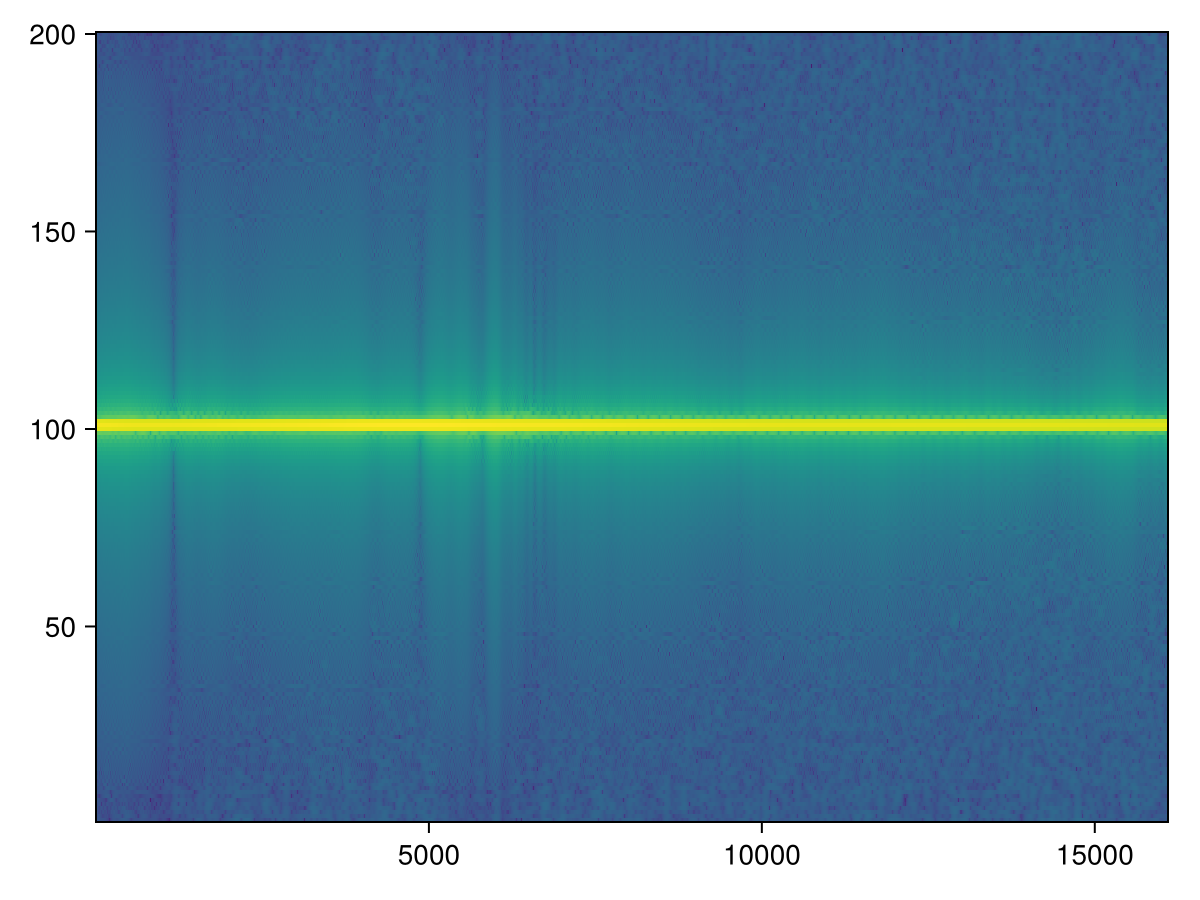

In [18]:
heatmap(fftshift(log.(abs2.(big_fft[:,:,2])), 2))

In [22]:
t, q, _, _, _, _ = load_qgsw_snapshot(data_directory, grid, Nsnapshots)

(1811.166f0, Float32[0.42056534 0.44346574 … 0.3872307 0.40170383; 0.39487457 0.411116 … 0.3789812 0.38446063; … ; 0.49814484 0.5401227 … 0.43452555 0.4634936; 0.45612752 0.48693404 … 0.40639392 0.4300068], [-0.045492879319549664 -0.04625335017056241 … -0.04390061274157897 -0.04470744623359858; -0.0443719150568027 -0.045083509172333586 … -0.04287726721985349 -0.043635500334175716; … ; -0.04780092450473157 -0.0486630361788934 … -0.04600292185441357 -0.04691267191636103; -0.046636993357427214 -0.04744785257142314 … -0.04494318637807829 -0.04580075854828906], [0.0630371918403001 0.0608465527045194 … 0.06652927009350955 0.06492031453368985; 0.0590411496254816 0.05688344782630397 … 0.0626014817068539 0.06093532760186651; … ; 0.07138257451914587 0.06905090177483643 … 0.07489133448189107 0.07331715191316607; 0.06716644064972298 0.06492259667758139 … 0.07064701416383344 0.06906416739919329], [0.0923278725154043 0.09637850327838508 … 0.08419299683320466 0.08825237958309762; 0.09033079842652303 

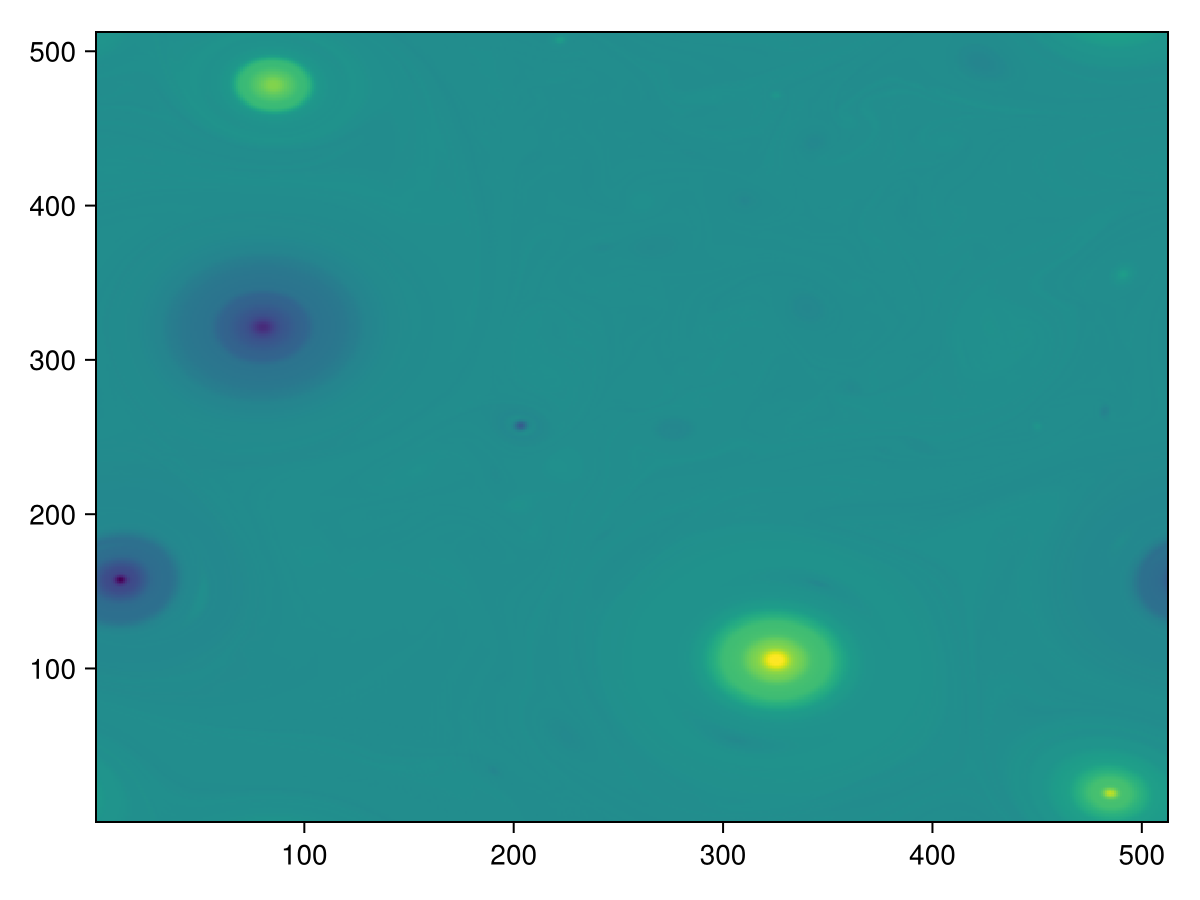

In [23]:
heatmap(q)